# Setup

In [1]:
# Import packages
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

# Word embeddings

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction).
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve.
These are called "pre-trained word embeddings".

## Learning word embeddings with the Embedding layer

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

### Load dataset

In [2]:
def load_data(name):
    dataset, info = tfds.load(name=name, with_info=True, as_supervised=True)
    train_dataset, test_dataset = dataset["train"], dataset["test"]
    return train_dataset, test_dataset

train_dataset, test_dataset = load_data(name="imdb_reviews")

In [3]:
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [4]:
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

### Create optimized dataset

In [5]:
BUFFER_SIZE = 5000
BUFFER_BS = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BS).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BS).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b"Jerry spies Tom listening to a creepy story on the radio and seizes the opportunity to scare his nemesis.<br /><br />I didn't find this particular episode that funny: the humour seemed rather constrained and the whole set up was kinda lame (Jerry is essentially the 'bad guy' in this one, tormenting poor Tom for no particular reason).<br /><br />There is the occasional flash of inspiration (such as Tom's literal 'heart in mouth' experience, and the moment when his nines lives are sucked out of his body), but, on the whole, this effort lacks the frenetic pacing, excellent animation and sheer wit of most of T&J's other cartoons.", shape=(), dtype=string)


### Data preprocessing

In [7]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [8]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 256

encoder = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

In [9]:
# Adapt encoder on training dataset
encoder.adapt(train_dataset.map(lambda text, label: text))

def vectorize_dataset(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the datasets
train_dataset = train_dataset.map(vectorize_dataset)
test_dataset = test_dataset.map(vectorize_dataset)

In [10]:
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(
[[  47   65  206 ...    0    0    0]
 [   2 1089  729 ...   30    2  203]
 [   4    1   63 ...    4 5543   47]
 ...
 [  11   19   13 ...   90  335   18]
 [  10  209    2 ... 4158   32    2]
 [  11   17    7 ...    0    0    0]], shape=(64, 256), dtype=int64)
Label: tf.Tensor(
[0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0
 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1], shape=(64,), dtype=int64)


In [11]:
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(
[[ 11  43   6 ...   0   0   0]
 [ 73  10 209 ...   0   0   0]
 [149   4 331 ...   0   0   0]
 ...
 [  4 365   5 ...   0   0   0]
 [ 10 209  11 ...   0   0   0]
 [  2 112 449 ...   0   0   0]], shape=(64, 256), dtype=int64)
Label: tf.Tensor(
[1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0], shape=(64,), dtype=int64)


### Modelling

In [12]:
def sequential_model():
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    # Normalization and dropout regularizer
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Sequence processing layer
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    # Dense layers with dropout regulaarizer
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation="relu"))

    # We add the classifier on top
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [13]:
# Instantiate model
model = sequential_model()

# Train and validate model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/10
391/391 [==============================] - 29s 74ms/step - loss: 0.5503 - accuracy: 0.7186 - val_loss: 0.4971 - val_accuracy: 0.7844
Epoch 2/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3510 - accuracy: 0.8534 - val_loss: 0.3557 - val_accuracy: 0.8561
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.2778 - accuracy: 0.8901 - val_loss: 0.3339 - val_accuracy: 0.8731
Epoch 4/10
391/391 [==============================] - 28s 73ms/step - loss: 0.2286 - accuracy: 0.9158 - val_loss: 0.3052 - val_accuracy: 0.8799
Epoch 5/10
391/391 [==============================] - 28s 71ms/step - loss: 0.1889 - accuracy: 0.9322 - val_loss: 0.3108 - val_accuracy: 0.8799
Epoch 6/10
391/391 [==============================] - 28s 73ms/step - loss: 0.1543 - accuracy: 0.9465 - val_loss: 0.3289 - val_accuracy: 0.8766


In [14]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")

391/391 [==============================] - 8s 20ms/step - loss: 0.3289 - accuracy: 0.8766
Test loss: 0.3288542628288269 | Test accuracy: 0.8765599727630615


### Visualize model performance

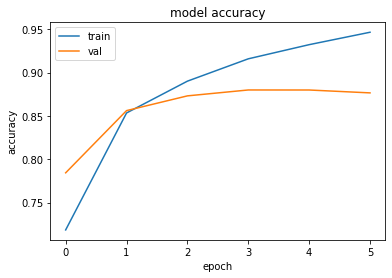

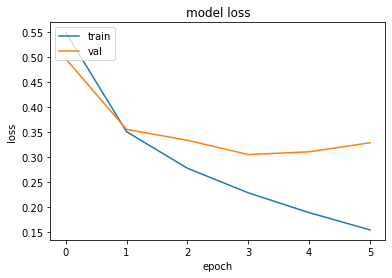

In [15]:
# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Using pre-trained embeddings

Download the GloVe word embeddings

Head to `https://nlp.stanford.edu/projects/glove/`, and download a pre-computed 
embeddings.

### Pre-processing embeddings

In [16]:
# Load pre-trained embedding
embeddings_index = dict()
with open(os.path.join("/home/nityan/embeddings/glove.6B.100d.txt")) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [17]:
# Get vocab for the corpus
vocabulary = encoder.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

print("Total number of words:", len(word_index))

# Now let's build an embedding matrix that we will load into an `Embedding` layer.
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i <= VOCAB_SIZE:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print("Embedding Matrix:", embedding_matrix.shape)

Total number of words: 10000
Embedding Matrix: (10000, 100)


### Modelling

In [18]:
def sequential_model():
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(
        VOCAB_SIZE, 
        EMBEDDING_DIM, 
        input_length=MAX_SEQUENCE_LENGTH, 
        trainable=False, 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)))

    # Normalization and dropout regularizer
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Sequence processing layer
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    # Dense layers with dropout regulaarizer
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation="relu"))

    # We add the classifier on top
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [19]:
# Instantiate model
model = sequential_model()

# Train and validate model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/10
391/391 [==============================] - 26s 68ms/step - loss: 0.5827 - accuracy: 0.7038 - val_loss: 0.5102 - val_accuracy: 0.7685
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.5002 - accuracy: 0.7596 - val_loss: 0.4568 - val_accuracy: 0.8059
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.4474 - accuracy: 0.7980 - val_loss: 0.4516 - val_accuracy: 0.7999
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4108 - accuracy: 0.8170 - val_loss: 0.3873 - val_accuracy: 0.8126
Epoch 5/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3878 - accuracy: 0.8272 - val_loss: 0.3590 - val_accuracy: 0.8502
Epoch 6/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3724 - accuracy: 0.8373 - val_loss: 0.3409 - val_accuracy: 0.8544
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3489 - accuracy: 0.8474 - val_loss: 0.3426 - val_accuracy:

In [20]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")

391/391 [==============================] - 8s 21ms/step - loss: 0.3461 - accuracy: 0.8763
Test loss: 0.34607282280921936 | Test accuracy: 0.8763200044631958


### Visualize model performance

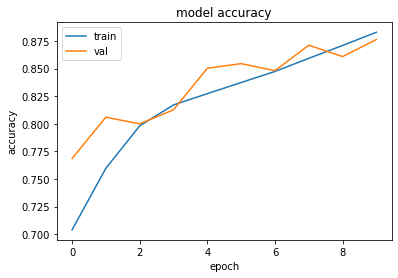

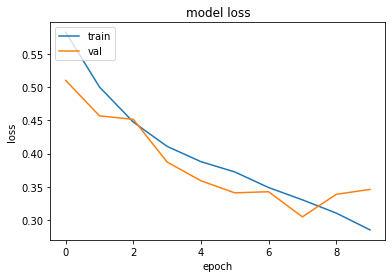

In [21]:
# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()